<a href="https://colab.research.google.com/github/kanadn/Code-Review-Activity/blob/main/AMLProjectTinkering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google drive, `cd` to the path

In [ ]:
#mount Google drive and connect to a path
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/AdvancedML/AMLProject/diht

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AdvancedML/AMLProject/diht


Install requirements

In [ ]:
!pip install -r requirements.txt
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 708.0 kB/s eta 0:00:00
     ━━━━━

For some reason we need a specific version of Pillow

In [ ]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diht 1.0 requires pillow==9.4.0, but you have pillow 9.0.0 which is incompatible.


These models are available in the code...

In [ ]:
import diht
print(diht.available_models())

['diht_vitb32_224px', 'diht_vitl14_336px', 'diht_vitb16_224px']


In [ ]:
import torch
import diht

from diht import model_zoo
from PIL import Image


text_tokenizer, image_transform, model = model_zoo.load_model(
    "diht_vitl14_336px", is_train=False
)

image = Image.open("infer_image.png").convert("RGB")
image = image_transform(image).unsqueeze(0)
text_captions = ["a mountain", "a beach", "a desert"]
text = text_tokenizer(text_captions)

with torch.no_grad():
    image_features, text_features, logit_scale = model(image, text)
    logits_per_image = logit_scale * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).numpy()

print(f"text captions: {text_captions}")
print(f"text caption probs: {probs}")

100%|█████████████████████████████████████| 1.59G/1.59G [01:51<00:00, 15.3MiB/s]


text captions: ['a mountain', 'a beach', 'a desert']
text caption probs: [[0.99370664 0.00514016 0.00115325]]


Sample code is working, now let's do some tinkering...

In [ ]:
text_captions2 = ["a mountain", "a lake", "a mountain and a lake"]
texts = text_tokenizer(text_captions2)

with torch.no_grad():
    image_features, text_features, logit_scale = model(image, texts)
    logits_per_image = logit_scale * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).numpy()

print(f"text captions: {text_captions2}")
print(f"text caption probs: {probs}")

text captions: ['a mountain', 'a lake', 'a mountain and a lake']
text caption probs: [[0.01392776 0.01522721 0.97084504]]


The model seems to be smart :)

Now let's import Google's [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset...  
Edit: Since the dataset only has image URLs, we need to fecth the images. This might take a lot of time, like, a lot!  
The following approach stores the dataset into a map, I think. It failed once and I need to restart everything again. Seems very inefficient. Skip this.

In [ ]:
!pip install datasets

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image

from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch


num_threads = 20
dset = load_dataset("conceptual_captions")
dset = dset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})


Found another way: https://github.com/igorbrigadir/DownloadConceptualCaptions

So I managed to download the data on my machine. Now the problem is, how to test this data?... I was planning to use Colab but looking at the sheer size of the data, Drive can't be used to store.  
So now our task is to find an optimal way to test this gigantic dataset. Either on cloud or on our machines.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dset = load_dataset("conceptual_captions")
dset_val = dset['validation'].select(range(100)) # Select the first 100 examples in validation set

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Dataset conceptual_captions downloaded and prepared to /root/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image

from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    print(batch)
    #batch = {k: v for k, v in batch.items() if v is not None}
    return batch


num_threads = 20

dset_val = dset_val.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

{'image_url': ['https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg', 'http://www.standard.net/image/2015/02/04/800x_a16-9_b0_q81_p1/winter-fly-fishing.jpg', 'http://indianapolis-photos.funcityfinder.com/files/2009/12/Clearwater-Crossing-Shopping-Center-sign-Indianapolis-Indiana.jpg', 'http://www.abc.net.au/news/image/9066492-3x2-700x467.jpg', 'https://www.featurepics.com/StockImage/20090316/carrying-globe-stock-image-1115085.jpg', 'http://i.dailymail.co.uk/i/pix/2014/11/05/1415187324676_wps_31_Home_is_a_little_Deer_Ivy.jpg', 'http://www.waste360.com/sites/waste360.com/files/styles/article_featured_standard/public/Trista%2002%20007_0.jpg?itok=F1eJZsX3', 'https://media.gettyimages.com/photos/young-woman-seated-on-the-beach-picture-id97545987?s=612x612', 'https://worldjourneysdiscover.files.wordpress.com/2014/07/kyoto-07.jpg?w=860&h=645', 'http://piquemagazine.uk/wp-content/uploads/2017/10/LPO-24-Feb-Albrecht-Menzel-%C2%AE-Anne-Hornemann-300dpi.

In [ ]:
dset_val

Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 100
})

In [ ]:
type(dset_val[0])

dict

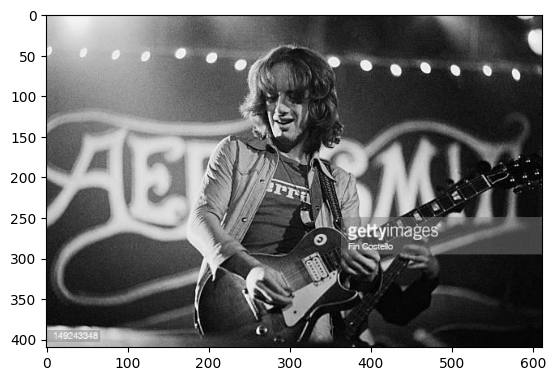

In [ ]:
import matplotlib.pyplot as plt

num_images = 100
count = 0
# Select the first num_images from the validation set
validation_set = dset_val.select(range(num_images))

# Display each image and its caption
for i in range(num_images):
    image_url = validation_set[i]['image_url']
    image = validation_set[i]['image']
    caption = validation_set[i]['caption']
    if image != None:
      plt.imshow(image)
      count += 1
    # plt.title(caption)
    # plt.show()


In [ ]:
count

80

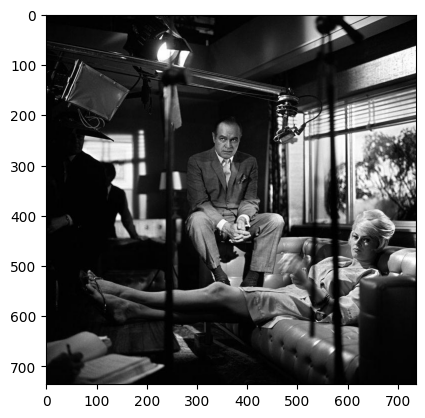

TypeError: ignored

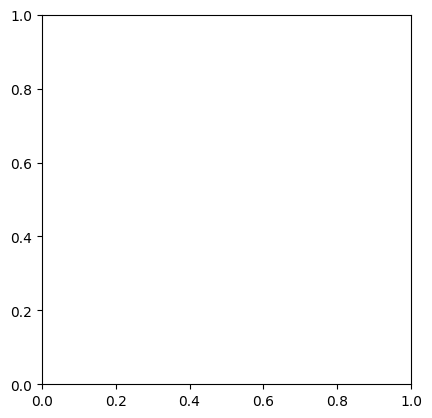

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    image = dset_val[i]["image"] # Assuming 'image' is the key for the image data
    plt.imshow(image)
    plt.show()

In [ ]:
type(dset)

datasets.dataset_dict.DatasetDict

In [ ]:
captions = dset['train']['caption']
print(captions[0])

a very typical bus station
